# Setup

In [31]:
import pickle
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [32]:
import util as ut

In [33]:
sns.set()
sns.set(style="darkgrid")

In [34]:
path = r'D:\Projects\HR-Analytics\HR Analytics\Data'
# path = input("Enter the data path:")
test = pd.read_csv(os.path.join(path,"test.csv"))

In [35]:
test.shape

(23490, 13)

In [36]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


# Checking for missing values

In [37]:
test.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [38]:
# check % missing values
test.isnull().sum()/test.shape[0] * 100

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.401873
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.713921
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
dtype: float64

4.4% of values in education and 7.71% in previous_year_rating are missing. Which means we will have to impute these values, rather than deleting the columns. Let us fill these values with 0.0 for previous year ratings and 'other' for education 

In [39]:
test['education'].fillna('null',inplace=True)
test['previous_year_rating'].fillna(0.0,inplace=True) 

In [40]:
test.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

# Feature Engineering

In [41]:
columns = ['gender','region','department','recruitment_channel']

for column in columns:
  d = {}
  for value in test[column].unique():
    d[value] = test.loc[test[column] == value][column].shape[0]

  test[column+'_count'] = test[column].apply(lambda x:d[x])
  print(column)
  print(test[column+'_count'].value_counts())

# bins = [-1,2,5,7,10,test['length_of_service'].max()]
# labels = ['0-2','3-5','5-7','8-10','>10']

bins = [-1,2,5,7,10,test['length_of_service'].max()]
labels = ['0-2','3-5','5-7','8-10','more_than_10']

test['length_of_service_binned'] = pd.cut(test['length_of_service'], bins,labels=labels)

bins = [-1, 29, 39, 49,test['age'].max()]
labels = ['less_than_30','30-39','40-49','more_equal_to_50']

# bins = [-1, 29, 39, 49,test['age'].max()]
# labels = ['<30','30-39','40-49','>=50']
test['age_binned'] = pd.cut(test['age'], bins,labels=labels)

gender
gender_count
16596    16596
6894      6894
Name: count, dtype: int64
region
region_count
5299    5299
2739    2739
1982    1982
1167    1167
1130    1130
1011    1011
844      844
775      775
710      710
595      595
590      590
571      571
269      538
516      516
433      433
414      414
410      410
361      361
350      350
342      342
337      337
326      326
298      298
273      273
238      238
219      219
215      215
180      180
179      179
155      155
147      147
126      126
20        20
Name: count, dtype: int64
department
department_count
7315    7315
4764    4764
3020    3020
3011    3011
2319    2319
1091    1091
1085    1085
445      445
440      440
Name: count, dtype: int64
recruitment_channel
recruitment_channel_count
13078    13078
9961      9961
451        451
Name: count, dtype: int64


In [43]:
test['KPIs_met >80%'] = ut.convert_to_categorical(test,'KPIs_met >80%')
test['awards_won?'] = ut.convert_to_categorical(test,'awards_won?')
#test['is_promoted'] = convert_to_categorical(test,'is_promoted')

In [45]:
test = ut.cont_to_cat(test,'is_multiple_training_completed','no_of_trainings')

is_multiple_training_completed
0    18928
1     4562
Name: count, dtype: int64


In [47]:
nominal = ['department','recruitment_channel','length_of_service_binned','age_binned','gender'] 
ordinal = ['education', 'KPIs_met >80%', 'awards_won?', 'is_multiple_testing_completed', 'region_high_employees']

test = ut.one_hot_encoding(test,nominal)

test['education'] = test['education'].map({'null':0,'Below Secondary':1,"Bachelor's":2,"Master's & above":3})
print(test['education'].value_counts())

for variable in test.columns:
  if(test[variable].dtypes == "object"): 
    #print(variable)
    test[variable] = test[variable].apply(lambda x:int(x))

#Dropping gender_f variable.
test.drop(['gender_f'],axis=1,inplace=True)

education
2    15578
3     6504
0     1034
1      374
Name: count, dtype: int64


<Axes: xlabel='log_no_of_trainings', ylabel='Density'>

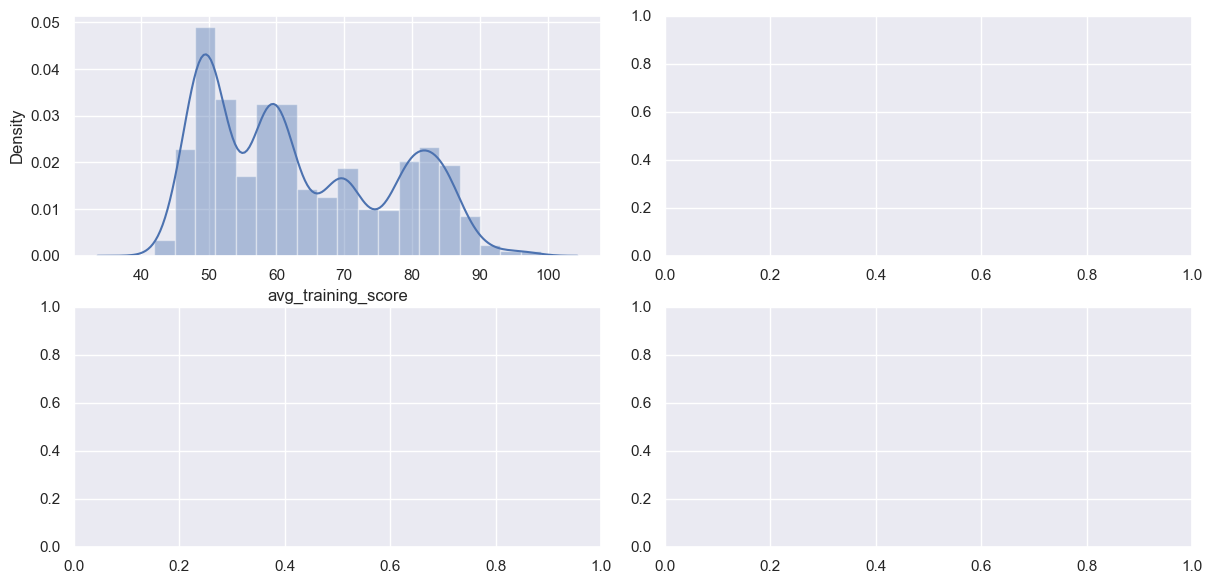

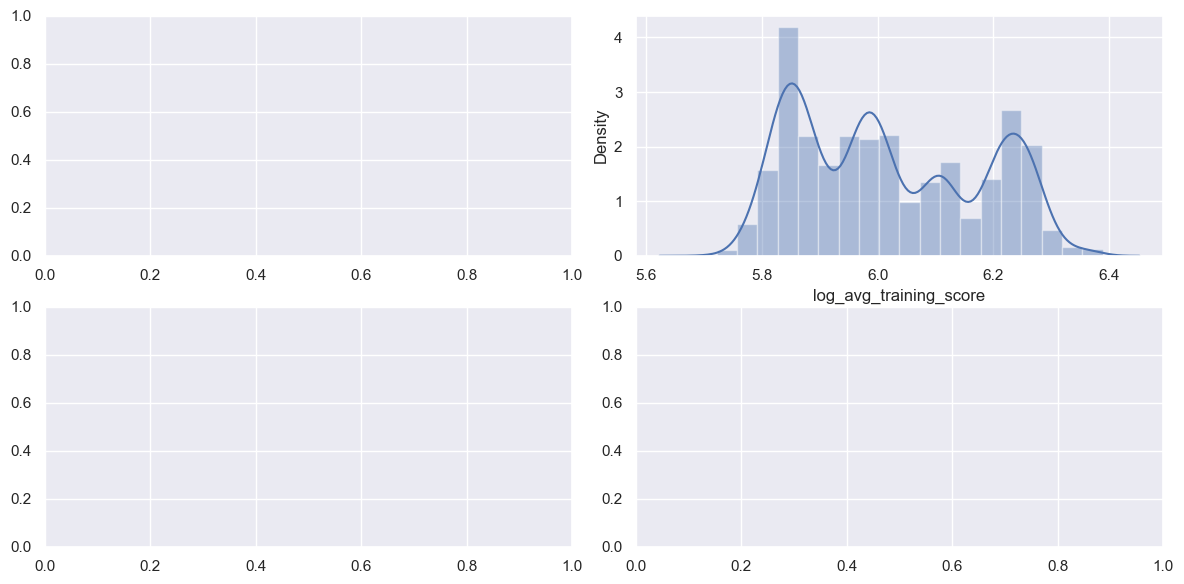

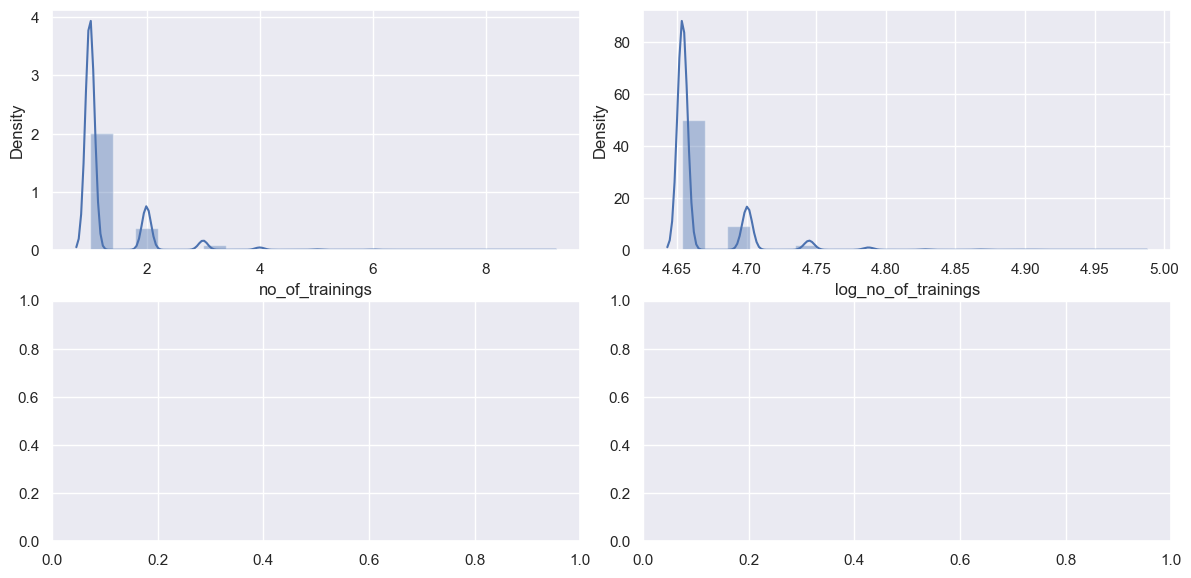

In [48]:
test['previous_year_rating'] = test['previous_year_rating'].apply(lambda x:int(x))

test['log_avg_training_score'] = pd.DataFrame(np.log(test['avg_training_score'] * 5+ 100))
test['log_no_of_trainings'] = pd.DataFrame(np.log(test['no_of_trainings'] * 5 + 100))

fig, axes = plt.subplots(nrows =2 , ncols=2, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4 = axes[0][0],axes[0][1],axes[1][0],axes[1][1]

sns.distplot(test['avg_training_score'], kde = True, bins = 20,ax=ax1)

fig, axes = plt.subplots(nrows =2 , ncols=2, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4 = axes[0][0],axes[0][1],axes[1][0],axes[1][1]

sns.distplot(test['log_avg_training_score'],kde = True, bins = 20,ax=ax2)


fig, axes = plt.subplots(nrows =2 , ncols=2, figsize=(12, 6))
fig.tight_layout()
ax1,ax2,ax3,ax4 = axes[0][0],axes[0][1],axes[1][0],axes[1][1]

sns.distplot(test['no_of_trainings'], kde = True, bins = 20,ax=ax1)
sns.distplot(test['log_no_of_trainings'],kde = True, bins = 20,ax=ax2)



In [49]:

to_add = ['log_no_of_trainings','log_avg_training_score']
to_drop = ['no_of_trainings','avg_training_score','employee_id','length_of_service_binned', 'age_binned']
test.drop(to_drop,axis=1,inplace=True,errors='ignore')

# changing num_cols values
for col in to_drop:
    if col in to_drop:
      num_cols.remove(col)

for col in to_add:
    num_cols.append(col)

print(num_cols)


['age', 'previous_year_rating', 'length_of_service', 'gender_count', 'region_count', 'department_count', 'recruitment_channel_count', 'log_no_of_trainings', 'log_avg_training_score']


In [50]:
#num_cols.remove('employee_id')
#test.drop(['employee_id'],axis=1,inplace=True)
test[num_cols] = (test[num_cols] - test[num_cols].min())/(test[num_cols].max()-test[num_cols].min())

# Loading models and parameters

In [51]:
# ! pip install catboost
# ! pip install lightgbm

Pickle files can be loaded from pickle files folder. One can enter the path accordingly

In [53]:
filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))

filename = 'lgbm_best_params.sav'
lgbm_params = pickle.load(open(filename, 'rb'))

filename = 'columns_selected'
columns = pickle.load(open(filename, 'rb'))

# Applying the models to test dataset

In [54]:
def get_final_output(clf,test,optimal_thresh,string):
  is_promoted = (clf.predict_proba(test)[:, 1] > optimal_thresh) * 1
  print(np.unique(is_promoted, return_counts=True)) 
  data = pd.read_csv(os.path.join(path,"test.csv"))
  data['is_promoted'] = pd.Series(is_promoted)
  output = data[['employee_id','is_promoted']]
  print(output['is_promoted'].value_counts(normalize=True) * 100)
  output.to_csv(string+'_final_submission.csv',index=False)

In [55]:
test_array = np.array(test[columns])
print(test_array.shape)

(23490, 36)


In [56]:
#fit model on training data pickled in numpy format and use it for making new predictions
filename = 'X_train.sav' 
X_train = pickle.load(open(filename, 'rb'))
filename = 'y_train.sav'
y_train = pickle.load(open(filename, 'rb'))

In [57]:
clf1 = CatBoostClassifier(verbose=0,**catboost_params)
clf1.fit(X_train,y_train)
get_final_output(clf1,test_array,0.25,'catboost')

(array([0, 1]), array([22087,  1403], dtype=int64))
is_promoted
0    94.027246
1     5.972754
Name: proportion, dtype: float64


In [58]:
clf2 = LGBMClassifier(class_weight='balanced',**lgbm_params)
y_train = y_train.values
clf2.fit(X_train,y_train)
get_final_output(clf2,test_array,0.8,'lgb')

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

In [59]:
estimators = [('lgbm', clf1),('catboost', clf2)]
clf = StackingClassifier(estimators=estimators, final_estimator = LGBMClassifier())
clf.fit(X_train,y_train)
get_final_output(clf,test_array,0.5,'stacked')

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

In [60]:
clf = clf = VotingClassifier(estimators=[('lgb', clf1), ('cb', clf2)],voting='soft', weights=[0.8,0.2],flatten_transform=True)
clf.fit(X_train,y_train)
get_final_output(clf,test_array,0.6,'averaged')

[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2800, number of negative: 30084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s